# Outlier detection in SMACOF solutions

In [1]:
from scripts.ClusterTS_MDS import ClusterVTECDataMDS

import numpy as np
from matplotlib.pyplot import subplots
from matplotlib import rcParams
from sklearn.cluster import HDBSCAN
from sklearn.metrics.cluster import calinski_harabasz_score, davies_bouldin_score

rcParams.update({
    "text.usetex": True
})

In [2]:
PTEX_dissim = np.loadtxt("./data/PTEX_DTW_matrix.dat", dtype= np.float64, delimiter = ",")
PTEX_dissim.shape

(4339, 4339)

SMACOF-dissim-classic with 2 components has a stress-1 value of 0.102657


np.float64(0.10265726762007561)

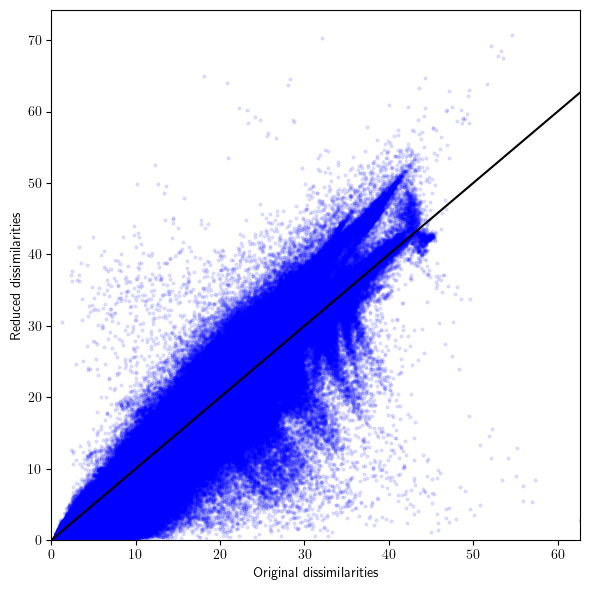

In [3]:
TEC_ClusterSeries = ClusterVTECDataMDS(dissimilarity = PTEX_dissim)
TEC_ClusterSeries.ComputeMDS(num_comps_mds = 2, method = "SMACOF-dissim-classic", max_iter = 1000, eps = 1e-6, verbose = 0)

--Scores with K-Means clustering--
SH coefficient = 0.713086098605985
CH index = 12206.295788390704
DB index = 0.4508544249281294
--Total series for every cluster--
0 -> 2450
1 -> 1268
2 -> 621


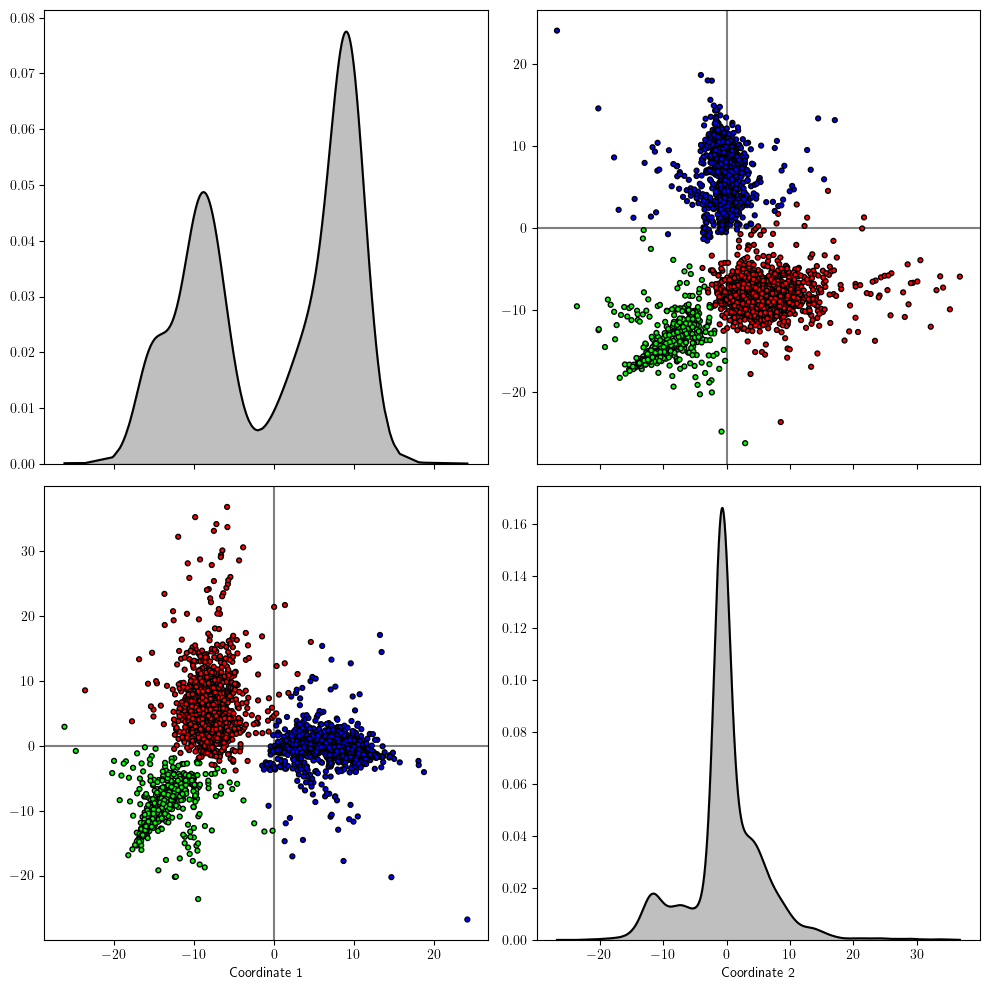

In [4]:
TEC_ClusterSeries.ClusterTSVectors(num_clusters = 3, cluster_method = "K-Means")
TEC_ClusterSeries.VisualizeClustering()

## Outlier detection using HDBSCAN

In [5]:
min_cluster_size_list = tuple(range(5, 55, 5))
CH_cluster_scores =[0]*len(min_cluster_size_list)
DB_cluster_scores =[0]*len(min_cluster_size_list)
number_found_clusters = [0]*len(min_cluster_size_list)

for k, num_samples in enumerate(min_cluster_size_list):
    HDBSCAN_Out = HDBSCAN(min_cluster_size = num_samples).fit(TEC_ClusterSeries.Xc_TS)
    CH_cluster_scores[k] = calinski_harabasz_score(TEC_ClusterSeries.Xc_TS, HDBSCAN_Out.labels_)
    DB_cluster_scores[k] = davies_bouldin_score(TEC_ClusterSeries.Xc_TS, HDBSCAN_Out.labels_)
    number_found_clusters[k] = len(np.unique(HDBSCAN_Out.labels_))

maximum_CH_index = np.argmax(CH_cluster_scores)
minimum_DB_index = np.argmin(DB_cluster_scores)
print("Optimal number of neighbours by CH score: ", min_cluster_size_list[maximum_CH_index])
print("Number of clusters given by maximum CH score: ", number_found_clusters[maximum_CH_index])
print("Optimal number of neighbours by DB score: ", min_cluster_size_list[minimum_DB_index])
print("Number of clusters given by minimum CH score: ", number_found_clusters[minimum_DB_index])

Optimal number of neighbours by CH score:  30
Number of clusters given by maximum CH score:  4
Optimal number of neighbours by DB score:  20
Number of clusters given by minimum CH score:  9


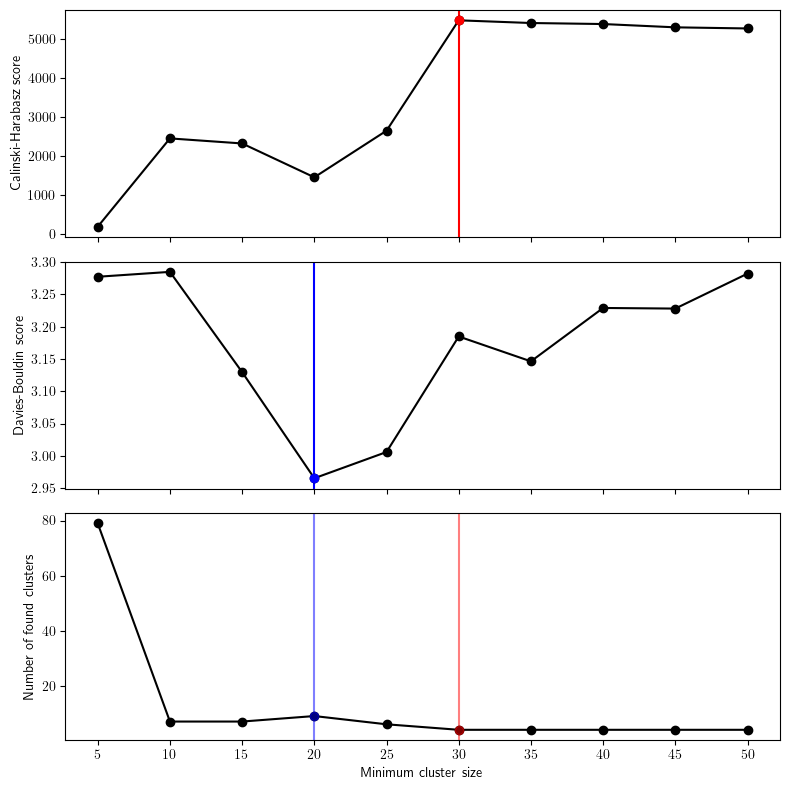

In [6]:
Figure, Subplot = subplots(3, 1, figsize = (8, 8), sharex = "col")

Subplot[0].axvline(min_cluster_size_list[maximum_CH_index], color = "red", zorder = 0)
Subplot[0].plot(min_cluster_size_list, CH_cluster_scores, "-ok", zorder = 1)
Subplot[0].scatter(min_cluster_size_list[maximum_CH_index], CH_cluster_scores[maximum_CH_index], c = "red", marker = "o", zorder = 2)

Subplot[1].axvline(min_cluster_size_list[minimum_DB_index], color = "blue", zorder = 0)
Subplot[1].plot(min_cluster_size_list, DB_cluster_scores, "-ok", zorder = 1)
Subplot[1].scatter(min_cluster_size_list[minimum_DB_index], DB_cluster_scores[minimum_DB_index], c = "blue", marker = "o", zorder = 2)

Subplot[2].axvline(min_cluster_size_list[minimum_DB_index], color = "blue", zorder = 0, alpha = 0.5)
Subplot[2].axvline(min_cluster_size_list[maximum_CH_index], color = "red", zorder = 0, alpha = 0.5)
Subplot[2].plot(min_cluster_size_list, number_found_clusters, "-ok", zorder = 1)
Subplot[2].scatter(min_cluster_size_list[maximum_CH_index], number_found_clusters[maximum_CH_index], c = "red", marker = "o", zorder = 2, alpha = 0.5)
Subplot[2].scatter(min_cluster_size_list[minimum_DB_index], number_found_clusters[minimum_DB_index], c = "blue", marker = "o", zorder = 2, alpha = 0.5)


Subplot[0].set_ylabel("Calinski-Harabasz score")
Subplot[1].set_ylabel("Davies-Bouldin score")
Subplot[2].set_ylabel("Number of found clusters")
Subplot[2].set_xlabel("Minimum cluster size")
Subplot[2].set_xticks(min_cluster_size_list)

Figure.tight_layout()

Size for minimum cluster:  20
Counter({np.int64(-1): 1492, np.int64(0): 1135, np.int64(7): 1020, np.int64(1): 533, np.int64(4): 51, np.int64(3): 30, np.int64(2): 27, np.int64(5): 27, np.int64(6): 24})


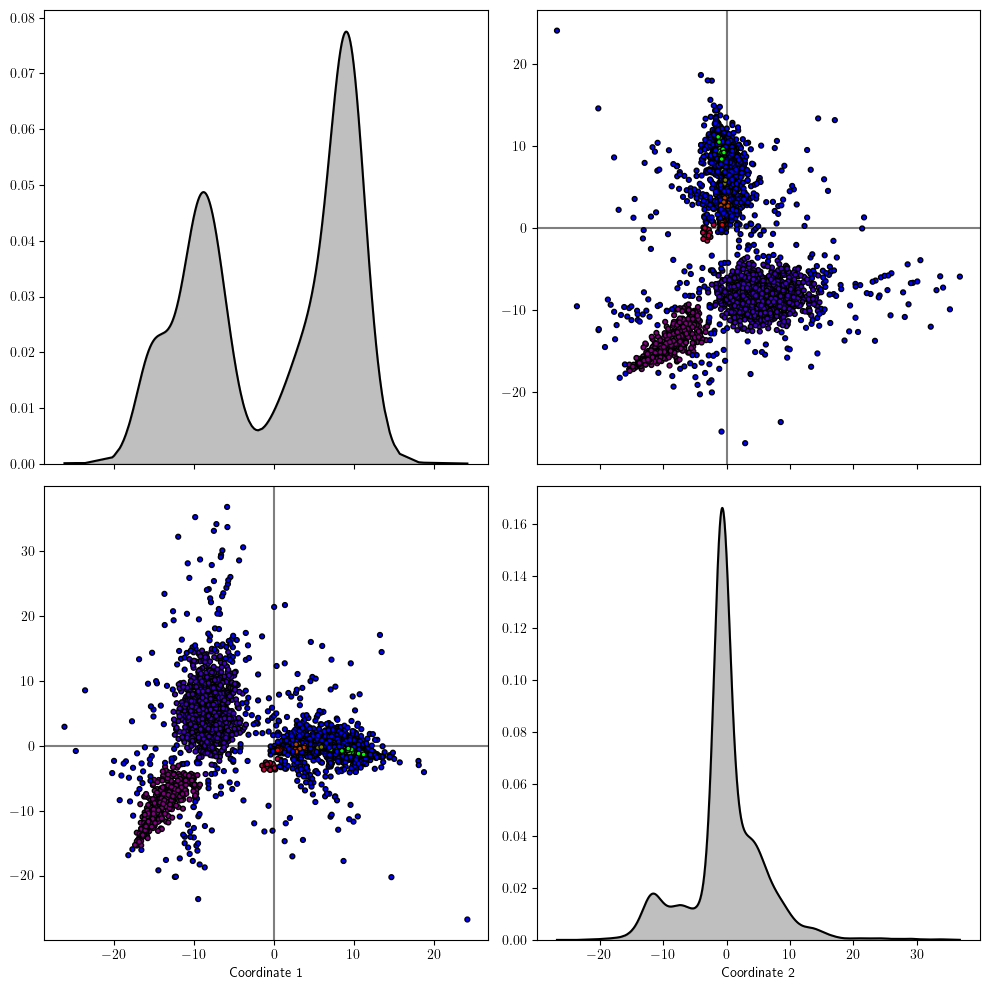

In [7]:
from collections import Counter

min_cluster_size = min(min_cluster_size_list[maximum_CH_index], min_cluster_size_list[minimum_DB_index])

print("Size for minimum cluster: ", min_cluster_size)
HDBSCAN_Out = HDBSCAN(min_cluster_size = min_cluster_size).fit(TEC_ClusterSeries.Xc_TS)
print(Counter(HDBSCAN_Out.labels_))
HDBSCAN_cluster_labels = np.where(HDBSCAN_Out.labels_ == -1, 1, 0)

TEC_ClusterSeries.VisualizeClustering(Labels = HDBSCAN_Out.labels_)

Size for minimum cluster:  30
Counter({np.int64(0): 2389, np.int64(1): 1133, np.int64(2): 539, np.int64(-1): 278})


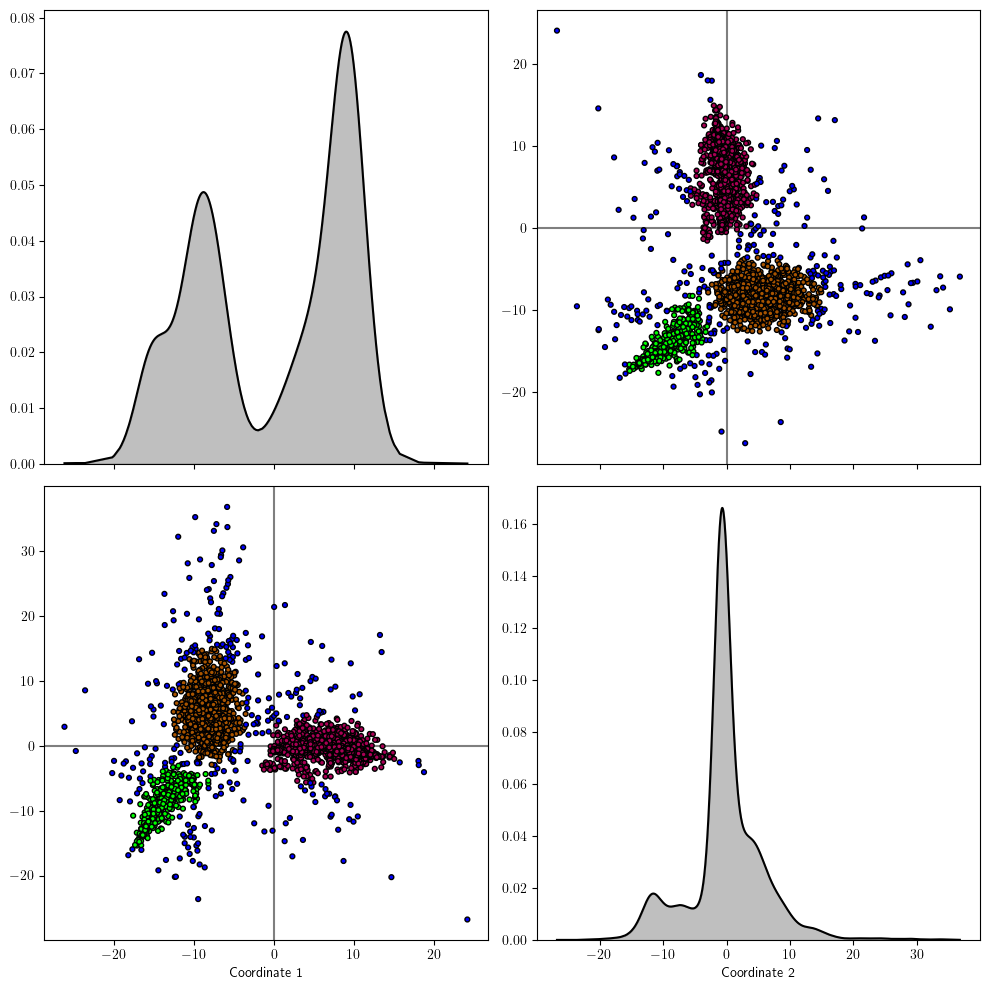

In [8]:
min_cluster_size = max(min_cluster_size_list[maximum_CH_index], min_cluster_size_list[minimum_DB_index])

print("Size for minimum cluster: ", min_cluster_size)
HDBSCAN_Out = HDBSCAN(min_cluster_size = min_cluster_size).fit(TEC_ClusterSeries.Xc_TS)
print(Counter(HDBSCAN_Out.labels_))
HDBSCAN_cluster_labels = np.where(HDBSCAN_Out.labels_ == -1, 1, 0)

TEC_ClusterSeries.VisualizeClustering(Labels = HDBSCAN_Out.labels_)

## SMACOF solution without outliers given by DBSCAN

In [9]:
def RemoveSameRowsAndColumns(A:np.ndarray, index) -> np.ndarray:
    return np.delete(np.delete(A, index, 0), index, 1)

In [10]:
IndexOutliers = np.argwhere(HDBSCAN_cluster_labels == 1)
IndexNotOutliers = np.argwhere(HDBSCAN_cluster_labels == 0)

print("Number of outliers: ", IndexOutliers.size)
print("Percentage of outlier: ", 100*IndexOutliers.size/TEC_ClusterSeries.Xc_TS.shape[0])

PTEX_dissim_no_noise = RemoveSameRowsAndColumns(PTEX_dissim, IndexOutliers)
PTEX_dissim_no_noise.shape

Number of outliers:  278
Percentage of outlier:  6.407006222631943


(4061, 4061)

SMACOF-dissim-classic with 2 components has a stress-1 value of 0.085194


np.float64(0.08519393854260703)

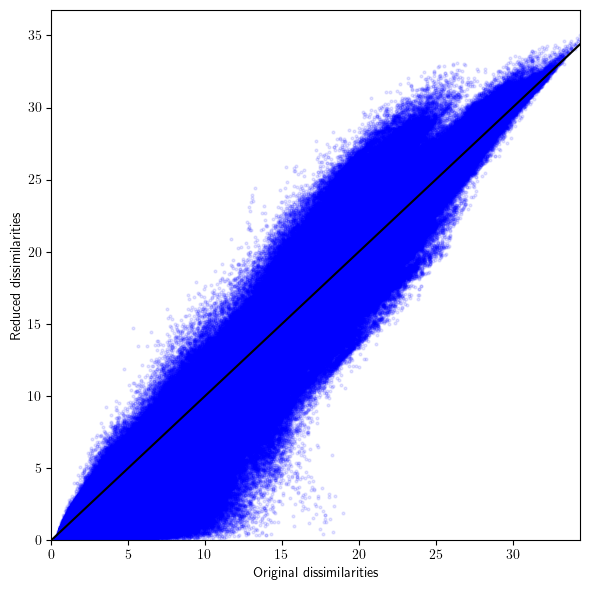

In [11]:
TEC_ClusterSeriesNoNoise = ClusterVTECDataMDS(dissimilarity = PTEX_dissim_no_noise)
TEC_ClusterSeriesNoNoise.ComputeMDS(num_comps_mds = 2, method = "SMACOF-dissim-classic", max_iter = 1000, eps = 1e-6, verbose = 0)

--Scores with K-Means clustering--
SH coefficient = 0.7534915476881738
CH index = 18586.99358704523
DB index = 0.3696021395594454
--Total series for every cluster--
0 -> 1133
1 -> 2389
2 -> 539


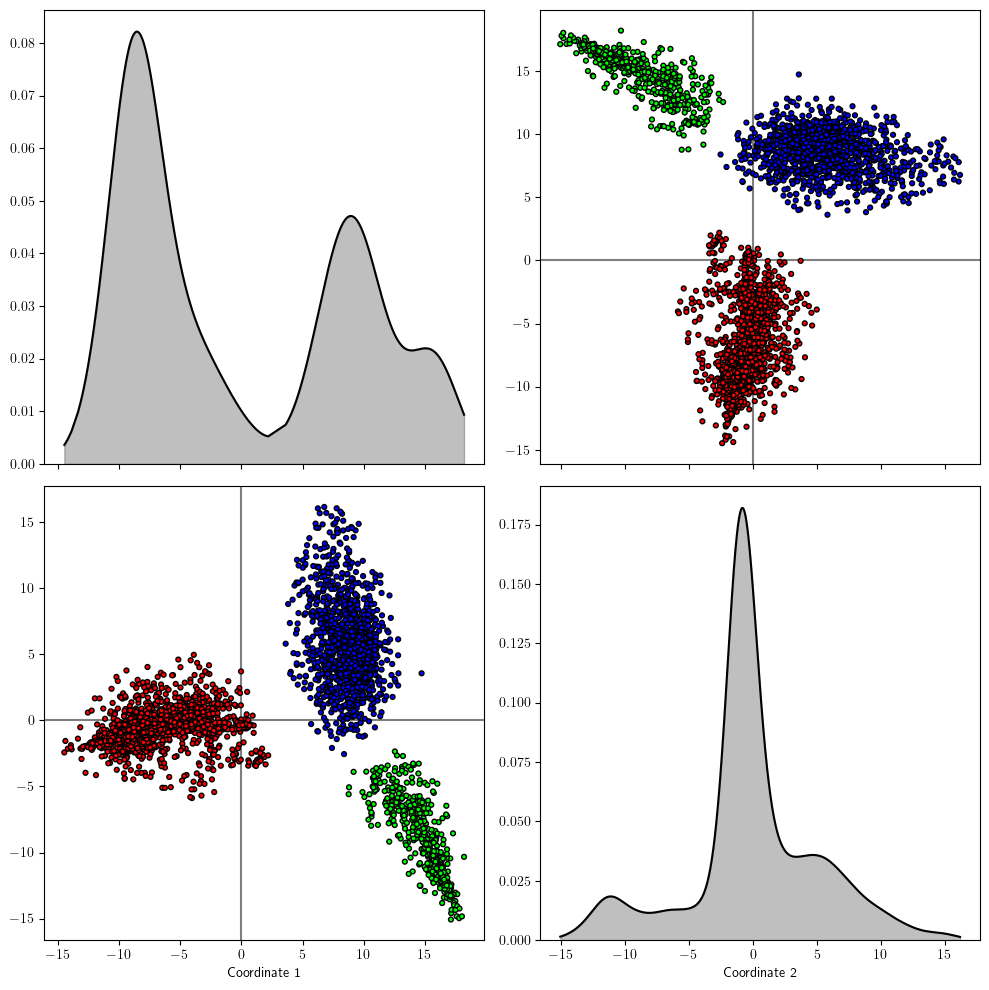

In [12]:
TEC_ClusterSeriesNoNoise.ClusterTSVectors(num_clusters = 3, cluster_method = "K-Means")
TEC_ClusterSeriesNoNoise.VisualizeClustering()

--Scores with GaussianMix clustering--
SH coefficient = 0.4333755537532015
CH index = 5042.660413849666
DB index = 0.9799166213779515
--Total series for every cluster--
0 -> 843
1 -> 1672
2 -> 1546


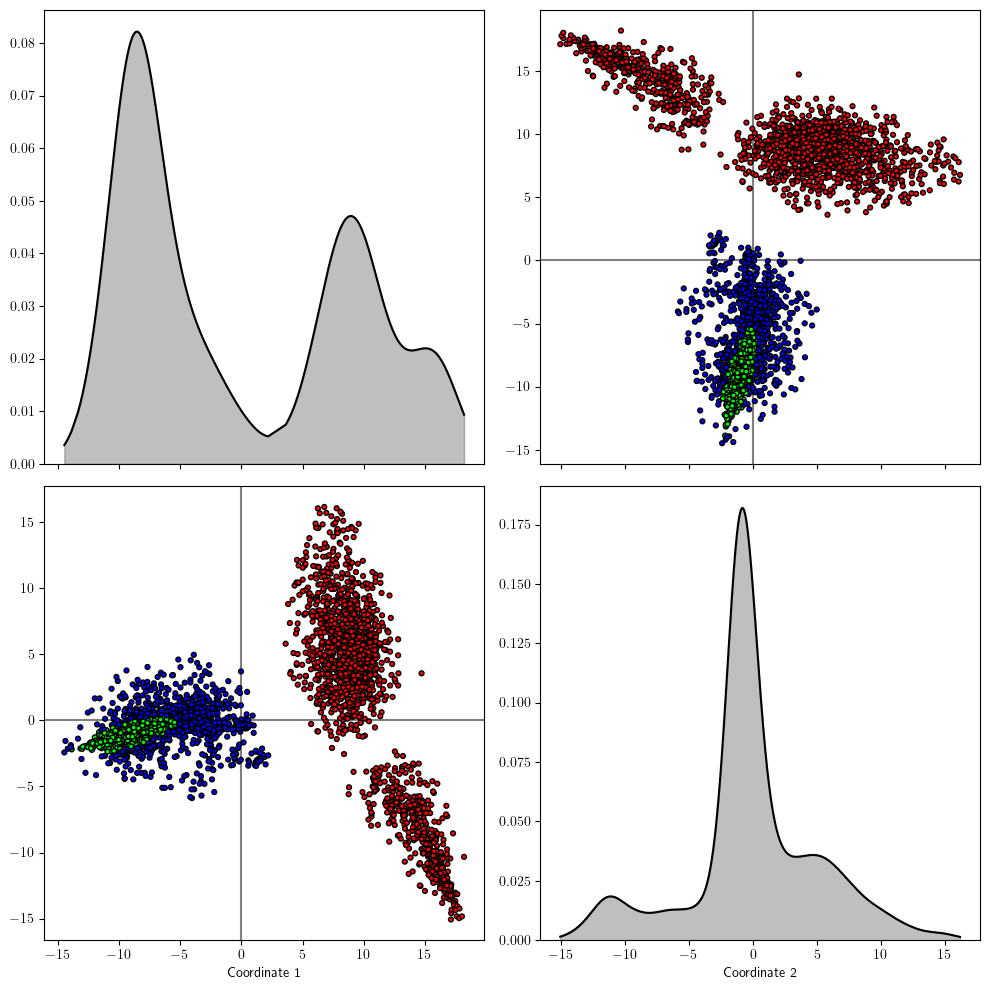

In [13]:
TEC_ClusterSeriesNoNoise.ClusterTSVectors(num_clusters = 3, cluster_method = "Gaussian")
TEC_ClusterSeriesNoNoise.VisualizeClustering()

In [14]:
PTEX_dissim_only_noise = RemoveSameRowsAndColumns(PTEX_dissim, IndexNotOutliers)
PTEX_dissim_only_noise.shape

(278, 278)

SMACOF-dissim-classic with 2 components has a stress-1 value of 0.225631


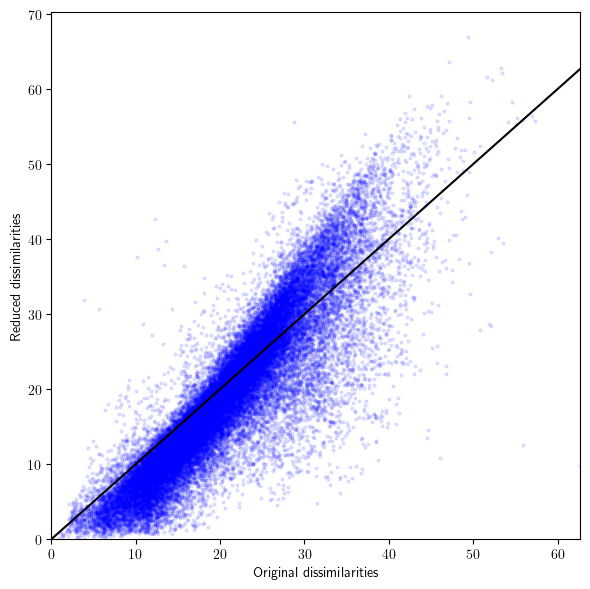

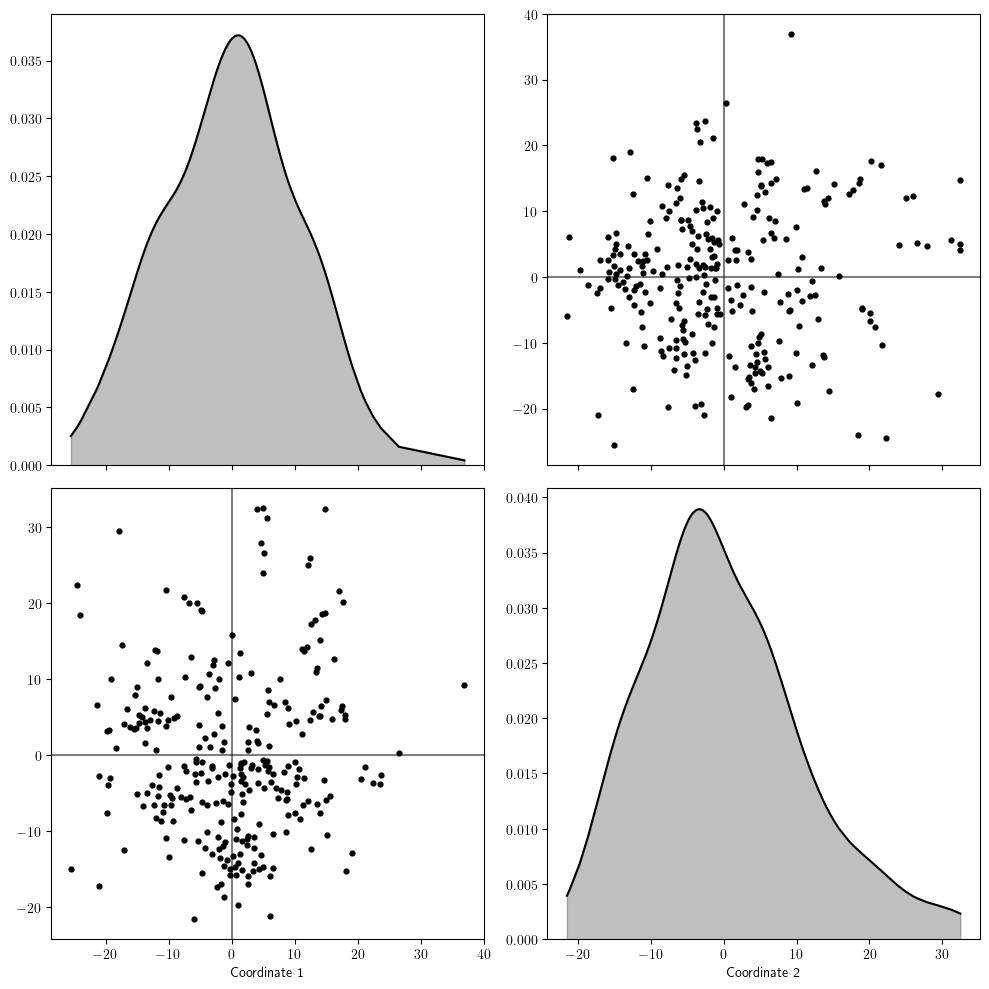

In [15]:
TEC_ClusterSeriesNoise = ClusterVTECDataMDS(dissimilarity = PTEX_dissim_only_noise)
TEC_ClusterSeriesNoise.ComputeMDS(num_comps_mds = 2, method = "SMACOF-dissim-classic", max_iter = 1000, eps = 1e-6, verbose = 0)
TEC_ClusterSeriesNoise.ClusterTSVectors(num_clusters = -1)
TEC_ClusterSeriesNoise.VisualizeClustering()

## Save outliers status for all TEC series

In [16]:
CompleteLabels = np.zeros(PTEX_dissim.shape[0], dtype = int)

TEC_ClusterSeriesNoNoise.ClusterTSVectors(num_clusters = 3, cluster_method = "K-Means")
CompleteLabels[IndexOutliers] = -1
CompleteLabels[IndexNotOutliers] = TEC_ClusterSeriesNoNoise.Xc_Labels.reshape(PTEX_dissim_no_noise.shape[0], 1)

--Scores with K-Means clustering--
SH coefficient = 0.7534915476881738
CH index = 18586.99358704523
DB index = 0.3696021395594454
--Total series for every cluster--
0 -> 2389
1 -> 1133
2 -> 539


In [17]:
with open("./data/PTEX_2018_2019_clustering.dat", "+w") as OutlierOuts:
    for n, label in enumerate(CompleteLabels):
        OutlierOuts.write(f"{n}, {label}\n")